# Ottawa Tabular Collision Data 2015-2017 #4# Create Machine Learning Model

In [1]:
import sys
print(sys.executable)
import os
import pandas as pd
import numpy as np

import pickle
import xgboost
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, Binarizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve
import matplotlib.pyplot as plt

import math 

import datetime
import time

print("Changing Directory")

basedir = 'C:\\Users\\Enrique\\PycharmProjects\\TestGeopandas'
os.chdir(basedir)

data_file = basedir + '\\Tabular Data 2015-2017 datafiles\\Ottawa Tabular Collision Data 2015-2017 FINAL DATA with Sampling and Events.csv'

C:\Users\Enrique\Anaconda3\envs\mlenv\python.exe
Changing Directory


# 1. Load the Collision Dataset with Sampling and Events

In [2]:
df = pd.read_csv(data_file, dtype = str, na_values = "", keep_default_na = False)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86988 entries, 0 to 86987
Data columns (total 59 columns):
ACCIDENT_DATE                 86988 non-null object
ACCIDENT_DATE_TIME            86988 non-null object
ACCIDENT_LOCATION             86979 non-null object
ACCIDENT_TIME                 86988 non-null object
CLASSIFICATION_OF_ACCIDENT    86988 non-null object
ENVIRONMENT_CONDITION         86985 non-null object
IMPACT_TYPE                   43494 non-null object
LATITUDE                      86988 non-null object
LIGHT                         86982 non-null object
LOCATION                      86988 non-null object
LOCATION_A                    86965 non-null object
LOCATION_B                    86965 non-null object
LONGITUDE                     86988 non-null object
ONS_ID                        86988 non-null object
ONS_NAME                      86988 non-null object
ROAD_DIRECTION                86988 non-null object
ROAD_LEN                      86988 non-null object
ROAD_NA

,ACCIDENT_DATE,ACCIDENT_DATE_TIME,ACCIDENT_LOCATION,ACCIDENT_TIME,CLASSIFICATION_OF_ACCIDENT,ENVIRONMENT_CONDITION,IMPACT_TYPE,LATITUDE,LIGHT,LOCATION,...,CARLETON_CALENDAR_FALL,COLLISION,ROAD_SINUOSITY_LOG,ROAD_LEN_LOG,SOLAR_AZIMUTH_LOG,SOLAR_ELEVATION_LOG,NUMBER_OF_COLLISIONS,STREET1,STREET2,STREET3
0,2015-01-01,2015-01-01 00:30:00,03 - At intersection,12:30:00 AM,03 - P.D. only,01 - Clear,02 - Angle,45.41934473,07 - Dark,LAURIER AVE @ O'CONNOR ST,...,0,1,0.0,0.0,3.1917101567954314,4.190260619051927,32,LAURIER AVE,@ O'CONNOR ST,NaN
1,2015-01-01,2015-01-01 13:15:00,03 - At intersection,1:15:00 PM,03 - P.D. only,03 - Snow,03 - Rear end,45.42876352,01 - Daylight,KING EDWARD AVE @ RIDEAU ST,...,0,1,0.0,0.0,5.303553633343283,2.93651291389402,88,KING EDWARD AVE,@ RIDEAU ST,NaN
2,2015-01-01,2015-01-01 13:54:00,03 - At intersection,1:54:00 PM,02 - Non-fatal injury,01 - Clear,05 - Turning movement,45.27524017,01 - Daylight,BEATRICE DR @ STRANDHERD DR,...,0,1,0.0,0.0,5.346726505755724,2.7763317085186157,35,BEATRICE DR,@ STRANDHERD DR,NaN
3,2015-01-01,2015-01-01 15:15:00,03 - At intersection,3:15:00 PM,02 - Non-fatal injury,01 - Clear,02 - Angle,45.39662951,01 - Daylight,QUEEN ELIZABETH DRWY @ QUEEN ELIZABETH PL,...,0,1,0.0,0.0,5.423627557513483,1.9726911717329554,11,QUEEN ELIZABETH DRWY,@ QUEEN ELIZABETH PL,NaN
4,2015-01-01,2015-01-01 17:30:00,02 - Intersection related,5:30:00 PM,03 - P.D. only,03 - Snow,03 - Rear end,45.48077499,05 - Dusk,OLD TENTH LINE RD @ TENTH LINE RD,...,0,1,0.0,0.0,5.523698412802438,2.580974118534234,32,OLD TENTH LINE RD,@ TENTH LINE RD,NaN


# 2. Clean the Dataset

In [3]:
df = df.drop(columns=['ACCIDENT_DATE','ACCIDENT_DATE_TIME','ACCIDENT_TIME','CLASSIFICATION_OF_ACCIDENT','LATITUDE',
                      'LONGITUDE', 'IMPACT_TYPE', 'ROAD_ROW_NUMBER','ROW_ID', 'SOLAR_AZIMUTH_LOG' , 
                      'ONS_ID', 
                      #'LOCATION_A', 'LOCATION_B',
                      #'STREET1','STREET2',
                      'STREET3',                     
                      'SOLAR_ELEVATION_LOG'],errors='ignore')

#df['COLLISION'] = df['COLLISION'].astype('int')
df = df.dropna(how='any',axis=0)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86136 entries, 0 to 86987
Data columns (total 46 columns):
ACCIDENT_LOCATION            86136 non-null object
ENVIRONMENT_CONDITION        86136 non-null object
LIGHT                        86136 non-null object
LOCATION                     86136 non-null object
LOCATION_A                   86136 non-null object
LOCATION_B                   86136 non-null object
ONS_NAME                     86136 non-null object
ROAD_DIRECTION               86136 non-null object
ROAD_LEN                     86136 non-null object
ROAD_NAME                    86136 non-null object
ROAD_SEGMENT                 86136 non-null object
ROAD_SINUOSITY               86136 non-null object
ROAD_SUBCLASS                86136 non-null object
ROAD_SUBTYPE                 86136 non-null object
ROAD_SURFACE_CONDITION       86136 non-null object
TILE_ID                      86136 non-null object
TRAFFIC_CONTROL              86136 non-null object
XCOORD                  

,ACCIDENT_LOCATION,ENVIRONMENT_CONDITION,LIGHT,LOCATION,LOCATION_A,LOCATION_B,ONS_NAME,ROAD_DIRECTION,ROAD_LEN,ROAD_NAME,...,SOLAR_ELEVATION,CARLETON_CALENDAR_WINTER,CARLETON_CALENDAR_SUMMER,CARLETON_CALENDAR_FALL,COLLISION,ROAD_SINUOSITY_LOG,ROAD_LEN_LOG,NUMBER_OF_COLLISIONS,STREET1,STREET2
0,03 - At intersection,01 - Clear,07 - Dark,LAURIER AVE @ O'CONNOR ST,LAURIER AVE,@ O'CONNOR ST,Centretown,NA,1.0,O'CONNOR ST @ LAURIER AVE W,...,-66.04,0,0,0,1,0.0,0.0,32,LAURIER AVE,@ O'CONNOR ST
1,03 - At intersection,03 - Snow,01 - Daylight,KING EDWARD AVE @ RIDEAU ST,KING EDWARD AVE,@ RIDEAU ST,Lowertown,NA,1.0,KING EDWARD AVE @ RIDEAU ST,...,18.85,0,0,0,1,0.0,0.0,88,KING EDWARD AVE,@ RIDEAU ST
2,03 - At intersection,01 - Clear,01 - Daylight,BEATRICE DR @ STRANDHERD DR,BEATRICE DR,@ STRANDHERD DR,Stonebridge - Halfmoon Bay - Heart's Desire,NA,1.0,STRANDHERD DR @ BEATRICE DR,...,16.06,0,0,0,1,0.0,0.0,35,BEATRICE DR,@ STRANDHERD DR
3,03 - At intersection,01 - Clear,01 - Daylight,QUEEN ELIZABETH DRWY @ QUEEN ELIZABETH PL,QUEEN ELIZABETH DRWY,@ QUEEN ELIZABETH PL,Glebe - Dows Lake,NA,1.0,QUEEN ELIZABETH DRWY @ BANK ST @ COLONEL BY DR...,...,7.19,0,0,0,1,0.0,0.0,11,QUEEN ELIZABETH DRWY,@ QUEEN ELIZABETH PL
4,02 - Intersection related,03 - Snow,05 - Dusk,OLD TENTH LINE RD @ TENTH LINE RD,OLD TENTH LINE RD,@ TENTH LINE RD,Queenswood Heights,NA,1.0,OLD TENTH LINE RD @ TENTH LINE RD,...,-13.21,0,0,0,1,0.0,0.0,32,OLD TENTH LINE RD,@ TENTH LINE RD


# 3. Encode Features 

## 3.1 Continuos Features

In [4]:
# Continuously valued features
float_feature_names = [
    'ROAD_LEN',
    'ROAD_SINUOSITY',
    'XCOORD',
    'YCOORD',
    'SOLAR_AZIMUTH',
    'SOLAR_ELEVATION',
    'ROAD_SINUOSITY_LOG',
    'ROAD_LEN_LOG',
    'NUMBER_OF_COLLISIONS'
]
float_features = df.xs(float_feature_names,axis=1).values

# Use scikit-learn's StandardScaler
scaler = StandardScaler()

float_scaled = scaler.fit_transform(float_features)

df[float_feature_names] = float_scaled

#with open('scalers.pkl','wb') as fp:
#    pickle.dump(scaler,fp)
    
df.info()
df.head()

C:\Users\Enrique\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Enrique\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 86136 entries, 0 to 86987
Data columns (total 46 columns):
ACCIDENT_LOCATION            86136 non-null object
ENVIRONMENT_CONDITION        86136 non-null object
LIGHT                        86136 non-null object
LOCATION                     86136 non-null object
LOCATION_A                   86136 non-null object
LOCATION_B                   86136 non-null object
ONS_NAME                     86136 non-null object
ROAD_DIRECTION               86136 non-null object
ROAD_LEN                     86136 non-null object
ROAD_NAME                    86136 non-null object
ROAD_SEGMENT                 86136 non-null object
ROAD_SINUOSITY               86136 non-null object
ROAD_SUBCLASS                86136 non-null object
ROAD_SUBTYPE                 86136 non-null object
ROAD_SURFACE_CONDITION       86136 non-null object
TILE_ID                      86136 non-null object
TRAFFIC_CONTROL              86136 non-null object
XCOORD                  

,ACCIDENT_LOCATION,ENVIRONMENT_CONDITION,LIGHT,LOCATION,LOCATION_A,LOCATION_B,ONS_NAME,ROAD_DIRECTION,ROAD_LEN,ROAD_NAME,...,SOLAR_ELEVATION,CARLETON_CALENDAR_WINTER,CARLETON_CALENDAR_SUMMER,CARLETON_CALENDAR_FALL,COLLISION,ROAD_SINUOSITY_LOG,ROAD_LEN_LOG,NUMBER_OF_COLLISIONS,STREET1,STREET2
0,03 - At intersection,01 - Clear,07 - Dark,LAURIER AVE @ O'CONNOR ST,LAURIER AVE,@ O'CONNOR ST,Centretown,NA,-0.385536,O'CONNOR ST @ LAURIER AVE W,...,-2.54712,0,0,0,1,-0.156158,-0.921845,-0.198603,LAURIER AVE,@ O'CONNOR ST
1,03 - At intersection,03 - Snow,01 - Daylight,KING EDWARD AVE @ RIDEAU ST,KING EDWARD AVE,@ RIDEAU ST,Lowertown,NA,-0.385536,KING EDWARD AVE @ RIDEAU ST,...,0.274805,0,0,0,1,-0.156158,-0.921845,0.96005,KING EDWARD AVE,@ RIDEAU ST
2,03 - At intersection,01 - Clear,01 - Daylight,BEATRICE DR @ STRANDHERD DR,BEATRICE DR,@ STRANDHERD DR,Stonebridge - Halfmoon Bay - Heart's Desire,NA,-0.385536,STRANDHERD DR @ BEATRICE DR,...,0.18206,0,0,0,1,-0.156158,-0.921845,-0.136532,BEATRICE DR,@ STRANDHERD DR
3,03 - At intersection,01 - Clear,01 - Daylight,QUEEN ELIZABETH DRWY @ QUEEN ELIZABETH PL,QUEEN ELIZABETH DRWY,@ QUEEN ELIZABETH PL,Glebe - Dows Lake,NA,-0.385536,QUEEN ELIZABETH DRWY @ BANK ST @ COLONEL BY DR...,...,-0.112798,0,0,0,1,-0.156158,-0.921845,-0.633097,QUEEN ELIZABETH DRWY,@ QUEEN ELIZABETH PL
4,02 - Intersection related,03 - Snow,05 - Dusk,OLD TENTH LINE RD @ TENTH LINE RD,OLD TENTH LINE RD,@ TENTH LINE RD,Queenswood Heights,NA,-0.385536,OLD TENTH LINE RD @ TENTH LINE RD,...,-0.790939,0,0,0,1,-0.156158,-0.921845,-0.198603,OLD TENTH LINE RD,@ TENTH LINE RD


## 3.2 Categorical Features

In [5]:
# Categorical valued features
categorical_feature_names = [
    'ACCIDENT_LOCATION',
    'ENVIRONMENT_CONDITION',
    'ROAD_SURFACE_CONDITION',
    'LIGHT',
    'LOCATION',
    'LOCATION_A',
    'LOCATION_B',
    'STREET1',
    'STREET2',
    #'STREET3',
    'ROAD_DIRECTION',
    'ROAD_NAME',
    'ROAD_SEGMENT',
    'ONS_NAME',
    'TRAFFIC_CONTROL',
    'ROAD_SUBCLASS',
    'ROAD_SUBTYPE',
    'TILE_ID'
]


# Use scikit-learn's LabelEncoder
le = LabelEncoder()

df[categorical_feature_names] = df[categorical_feature_names].apply(lambda col: le.fit_transform(col))

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86136 entries, 0 to 86987
Data columns (total 46 columns):
ACCIDENT_LOCATION            86136 non-null int32
ENVIRONMENT_CONDITION        86136 non-null int32
LIGHT                        86136 non-null int32
LOCATION                     86136 non-null int32
LOCATION_A                   86136 non-null int32
LOCATION_B                   86136 non-null int32
ONS_NAME                     86136 non-null int32
ROAD_DIRECTION               86136 non-null int32
ROAD_LEN                     86136 non-null object
ROAD_NAME                    86136 non-null int32
ROAD_SEGMENT                 86136 non-null int32
ROAD_SINUOSITY               86136 non-null object
ROAD_SUBCLASS                86136 non-null int32
ROAD_SUBTYPE                 86136 non-null int32
ROAD_SURFACE_CONDITION       86136 non-null int32
TILE_ID                      86136 non-null int32
TRAFFIC_CONTROL              86136 non-null int32
XCOORD                       86136 non-

,ACCIDENT_LOCATION,ENVIRONMENT_CONDITION,LIGHT,LOCATION,LOCATION_A,LOCATION_B,ONS_NAME,ROAD_DIRECTION,ROAD_LEN,ROAD_NAME,...,SOLAR_ELEVATION,CARLETON_CALENDAR_WINTER,CARLETON_CALENDAR_SUMMER,CARLETON_CALENDAR_FALL,COLLISION,ROAD_SINUOSITY_LOG,ROAD_LEN_LOG,NUMBER_OF_COLLISIONS,STREET1,STREET2
0,2,1,7,5988,1982,1127,23,1,-0.385536,3936,...,-2.54712,0,0,0,1,-0.156158,-0.921845,-0.198603,1982,1127
1,2,3,1,5750,1892,1351,62,1,-0.385536,2987,...,0.274805,0,0,0,1,-0.156158,-0.921845,0.96005,1892,1351
2,2,1,1,978,272,1617,95,1,-0.385536,5252,...,0.18206,0,0,0,1,-0.156158,-0.921845,-0.136532,272,1617
3,2,1,1,7979,2657,1291,41,1,-0.385536,4375,...,-0.112798,0,0,0,1,-0.156158,-0.921845,-0.633097,2657,1291
4,1,3,5,7396,2447,1675,83,1,-0.385536,4018,...,-0.790939,0,0,0,1,-0.156158,-0.921845,-0.198603,2447,1675


## 3.3 Binary Features

In [6]:
# Binay valued features
binary_feature_names = [
    'COLLISION',
    'OTTAWA_FURY_SOCCER',
    'OTTAWA_SENATORS_HOCKEY',
    'OTTAWA_67S_HOCKEY',
    'OTTAWA_REDBLACKS_FOOTBALL',
    'OTTAWA_RAVENS_FOOTBALL',
    'OTTAWA_GEEGEES_FOOTBALL',
    'OTTAWA_STATUTORY_HOLIDAYS',     
    'OTTAWA_CHAMPIONS_BBC',
    'CARLETON_CALENDAR_WINTER',
    'CARLETON_CALENDAR_SUMMER',
    'CARLETON_CALENDAR_FALL'
]
binary_features = df.xs(binary_feature_names,axis=1).values


# Use scikit-learn's Binarizer
binarizer = Binarizer()

binary_transformed = binarizer.fit_transform(binary_features)
df[binary_feature_names] = binary_transformed

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86136 entries, 0 to 86987
Data columns (total 46 columns):
ACCIDENT_LOCATION            86136 non-null int32
ENVIRONMENT_CONDITION        86136 non-null int32
LIGHT                        86136 non-null int32
LOCATION                     86136 non-null int32
LOCATION_A                   86136 non-null int32
LOCATION_B                   86136 non-null int32
ONS_NAME                     86136 non-null int32
ROAD_DIRECTION               86136 non-null int32
ROAD_LEN                     86136 non-null object
ROAD_NAME                    86136 non-null int32
ROAD_SEGMENT                 86136 non-null int32
ROAD_SINUOSITY               86136 non-null object
ROAD_SUBCLASS                86136 non-null int32
ROAD_SUBTYPE                 86136 non-null int32
ROAD_SURFACE_CONDITION       86136 non-null int32
TILE_ID                      86136 non-null int32
TRAFFIC_CONTROL              86136 non-null int32
XCOORD                       86136 non-

,ACCIDENT_LOCATION,ENVIRONMENT_CONDITION,LIGHT,LOCATION,LOCATION_A,LOCATION_B,ONS_NAME,ROAD_DIRECTION,ROAD_LEN,ROAD_NAME,...,SOLAR_ELEVATION,CARLETON_CALENDAR_WINTER,CARLETON_CALENDAR_SUMMER,CARLETON_CALENDAR_FALL,COLLISION,ROAD_SINUOSITY_LOG,ROAD_LEN_LOG,NUMBER_OF_COLLISIONS,STREET1,STREET2
0,2,1,7,5988,1982,1127,23,1,-0.385536,3936,...,-2.54712,0.0,0.0,0.0,1.0,-0.156158,-0.921845,-0.198603,1982,1127
1,2,3,1,5750,1892,1351,62,1,-0.385536,2987,...,0.274805,0.0,0.0,0.0,1.0,-0.156158,-0.921845,0.96005,1892,1351
2,2,1,1,978,272,1617,95,1,-0.385536,5252,...,0.18206,0.0,0.0,0.0,1.0,-0.156158,-0.921845,-0.136532,272,1617
3,2,1,1,7979,2657,1291,41,1,-0.385536,4375,...,-0.112798,0.0,0.0,0.0,1.0,-0.156158,-0.921845,-0.633097,2657,1291
4,1,3,5,7396,2447,1675,83,1,-0.385536,4018,...,-0.790939,0.0,0.0,0.0,1.0,-0.156158,-0.921845,-0.198603,2447,1675


# 4. Creation of Training and Test Datasets

In [7]:
Y_df = df['COLLISION']
X_df = df.drop(columns=['COLLISION'])

Y = Y_df.values
X = X_df.values
feature_names = X_df.columns.tolist()

print(Y)
print(feature_names)

[1. 1. 1. ... 0. 0. 0.]
['ACCIDENT_LOCATION', 'ENVIRONMENT_CONDITION', 'LIGHT', 'LOCATION', 'LOCATION_A', 'LOCATION_B', 'ONS_NAME', 'ROAD_DIRECTION', 'ROAD_LEN', 'ROAD_NAME', 'ROAD_SEGMENT', 'ROAD_SINUOSITY', 'ROAD_SUBCLASS', 'ROAD_SUBTYPE', 'ROAD_SURFACE_CONDITION', 'TILE_ID', 'TRAFFIC_CONTROL', 'XCOORD', 'YCOORD', 'ACCIDENT_DATE_daym', 'ACCIDENT_DATE_dayw', 'ACCIDENT_DATE_dayy', 'ACCIDENT_DATE_month', 'ACCIDENT_DATE_weekm', 'ACCIDENT_DATE_weeky', 'ACCIDENT_DATE_hour', 'ACCIDENT_DATE_year', 'OTTAWA_FURY_SOCCER', 'OTTAWA_SENATORS_HOCKEY', 'OTTAWA_67S_HOCKEY', 'OTTAWA_REDBLACKS_FOOTBALL', 'OTTAWA_RAVENS_FOOTBALL', 'OTTAWA_GEEGEES_FOOTBALL', 'OTTAWA_STATUTORY_HOLIDAYS', 'OTTAWA_CHAMPIONS_BBC', 'SOLAR_AZIMUTH', 'SOLAR_ELEVATION', 'CARLETON_CALENDAR_WINTER', 'CARLETON_CALENDAR_SUMMER', 'CARLETON_CALENDAR_FALL', 'ROAD_SINUOSITY_LOG', 'ROAD_LEN_LOG', 'NUMBER_OF_COLLISIONS', 'STREET1', 'STREET2']


# 5. Define Model Variables and Parameters (Gradient Boosting Trees)

In [8]:
feature_sel = range(len(feature_names))
Xs = X[:,feature_sel]
X_train, X_test, y_train, y_test = train_test_split(Xs, Y, test_size=0.1)
fnames = np.array(feature_names)[feature_sel]

X_train = xgboost.DMatrix(X_train,label=y_train,feature_names=fnames)
X_test =  xgboost.DMatrix(X_test,label=y_test,feature_names=fnames)


#params = {
#    'n_estimators': 200,
#    'max_depth':10,
#    'min_child_weight': 1.0,
#    'reg_lambda': 1.0,
#    'reg_alpha':0.0,
#    'objective':'binary:logistic',
#    'seed': 2019
#}

params = {
    'max_depth':6,
    'min_child_weight': 5.0,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'scale_pos_weight':1.0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'subsample':0.8,    
    'eta':0.3,
    'seed': 2019
}

#params = {
#    'max_depth':6,
#    'min_child_weight': 5.0,
#    'reg_lambda': 1.0,
#    'reg_alpha':0.0,
#    'scale_pos_weight':1.0,
#    'eval_metric':'auc',
#    'objective':'binary:logistic',
#    'subsample':0.8,    
#    'eta':0.3,
#    'seed': 2019,
#    'n_estimators': 10,
#}

# 6. Train the Model

In [9]:
booster = xgboost.train(params,X_train)
#xgboost.plot_tree(booster)

[11:17:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[11:17:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[11:17:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[11:17:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[11:17:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[11:17:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[11:17:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

In [10]:
print(fnames)

['ACCIDENT_LOCATION' 'ENVIRONMENT_CONDITION' 'LIGHT' 'LOCATION'
 'LOCATION_A' 'LOCATION_B' 'ONS_NAME' 'ROAD_DIRECTION' 'ROAD_LEN'
 'ROAD_NAME' 'ROAD_SEGMENT' 'ROAD_SINUOSITY' 'ROAD_SUBCLASS'
 'ROAD_SUBTYPE' 'ROAD_SURFACE_CONDITION' 'TILE_ID' 'TRAFFIC_CONTROL'
 'XCOORD' 'YCOORD' 'ACCIDENT_DATE_daym' 'ACCIDENT_DATE_dayw'
 'ACCIDENT_DATE_dayy' 'ACCIDENT_DATE_month' 'ACCIDENT_DATE_weekm'
 'ACCIDENT_DATE_weeky' 'ACCIDENT_DATE_hour' 'ACCIDENT_DATE_year'
 'OTTAWA_FURY_SOCCER' 'OTTAWA_SENATORS_HOCKEY' 'OTTAWA_67S_HOCKEY'
 'OTTAWA_REDBLACKS_FOOTBALL' 'OTTAWA_RAVENS_FOOTBALL'
 'OTTAWA_GEEGEES_FOOTBALL' 'OTTAWA_STATUTORY_HOLIDAYS'
 'OTTAWA_CHAMPIONS_BBC' 'SOLAR_AZIMUTH' 'SOLAR_ELEVATION'
 'CARLETON_CALENDAR_WINTER' 'CARLETON_CALENDAR_SUMMER'
 'CARLETON_CALENDAR_FALL' 'ROAD_SINUOSITY_LOG' 'ROAD_LEN_LOG'
 'NUMBER_OF_COLLISIONS' 'STREET1' 'STREET2']


## 6.1 Feature Importance

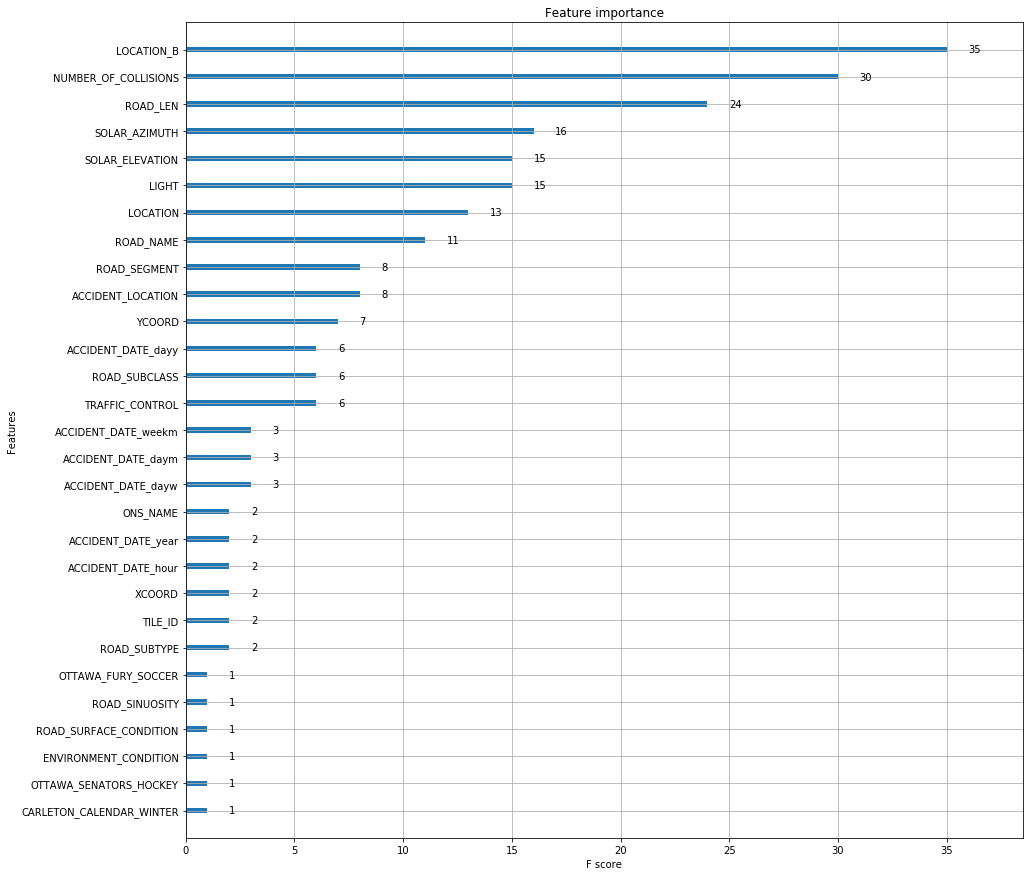

In [11]:
plt.figure(figsize=(15,15))
xgboost.plot_importance(booster,ax=plt.gca(),importance_type='weight')

In [12]:
booster.save_model('0002.model')

# 7. Using the Model for Test Data (Prediction) and Evaluate the Performance

## 7.1 ROC Curve

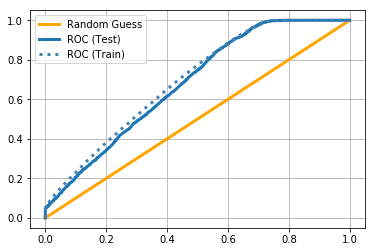

In [13]:
y_pred_test = booster.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_test)

y_pred_train = booster.predict(X_train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange',lw=3)
plt.plot(fpr,tpr,label='ROC (Test)',lw=3)
plt.plot(fpr_train,tpr_train,'r:',label='ROC (Train)',color='steelblue',lw=3)
plt.grid()
plt.legend()

## 7.2 TPR / FPR Curve

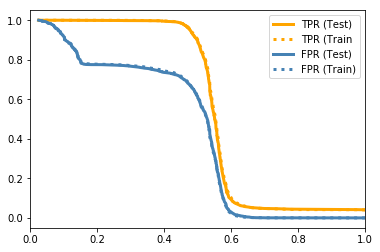

In [14]:
plt.plot(thresholds,tpr,'r-',label='TPR (Test)',color='orange',lw=3)
plt.plot(thresholds_train,tpr_train,'r:',label='TPR (Train',color='orange',lw=3)
plt.plot(thresholds,fpr,'r-',label='FPR (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,fpr_train,'r:',label='FPR (Train)',color='steelblue',lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.legend()

## 7.3 Precision/Recall (PR)

<Figure size 1080x1080 with 0 Axes>

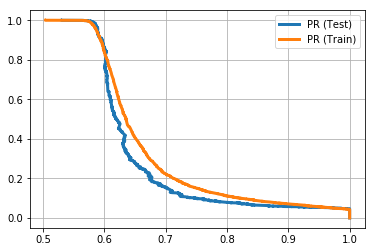

In [15]:
plt.figure(figsize=(15,15))

y_pred_test = booster.predict(X_test)
y_pred_train = booster.predict(X_train)

precision,recall,thresholds = precision_recall_curve(y_test,y_pred_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot(precision,recall,label='PR (Test)',lw=3)
plt.plot(precision_train,recall_train,label='PR (Train)',lw=3)

plt.grid()
plt.legend()

In [16]:
len(X_train.feature_names)

45

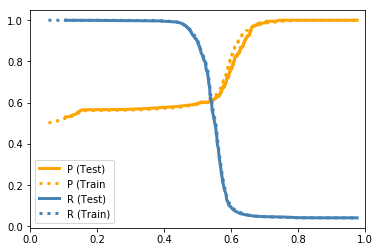

In [17]:
plt.plot(thresholds,precision[:-1],'r-',label='P (Test)',color='orange',lw=3)
plt.plot(thresholds_train,precision_train[:-1],'r:',label='P (Train',color='orange',lw=3)
plt.plot(thresholds,recall[:-1],'r-',label='R (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,recall_train[:-1],'r:',label='R (Train)',color='steelblue',lw=3)
#plt.plot([0,1],[0,1],'k-',lw=2)
plt.gca().set_xbound(lower=0,upper=1)
plt.legend()

## 7.4 Model Accuracy Results

In [18]:
y_pred_test = booster.predict(X_test) > 0.19
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test AP:',average_precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(X_test)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))
print('=============================================')
y_pred_train = booster.predict(X_train) > 0.19
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Test AP:',average_precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(X_train)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))

Test Accuracy: 0.614580914789877
Test F1: 0.723010178541632
Test Precision: 0.5664052287581699
Test AP: 0.5663616134793875
Test Recall: 0.9993081180811808
Test AUC: 0.6790874404185838
Train Accuracy: 0.6111039446866696
Train F1: 0.7200326882359497
Train Precision: 0.5625643927851058
Test AP: 0.5625595616950789
Train Recall: 0.9999226225787315
Train AUC: 0.6955087644853892


## 7.5 Cross-validation (in process, not working completely)

In [19]:
#booster_cv = xgboost.cv(params,data = X_train)

print ('Start cross validation')
cvresult = xgboost.cv(params, X_train, num_boost_round=100, nfold=5, metrics=['auc','error'],
                      early_stopping_rounds=100, stratified=True, seed=2019,
                      callbacks=[xgboost.callback.print_evaluation(show_stdv=True)])

Start cross validation
[11:17:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[11:17:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[11:17:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[11:17:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[11:17:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-auc:0.652719+0.00202399	train-error:0.384494+0.00179707	test-auc:0.648025+0.00383627	test-error:0.385503+0.00270859
[11:17:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[11:17:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[11:17:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[11:17:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-auc:0.698066+0.00369762	train-error:0.356073+0.00490356	test-auc:0.677187+0.00372021	test-error:0.365445+0.0057176
[11:17:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[11:17:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[11:17:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra node

[11:17:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[18]	train-auc:0.725648+0.00557377	train-error:0.340042+0.00613322	test-auc:0.682125+0.00402208	test-error:0.360298+0.00546937
[11:17:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[11:17:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[11:17:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[11:17:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[11:17:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra n

[11:18:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[11:18:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[11:18:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[11:18:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[11:18:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[28]	train-auc:0.751214+0.00386391	train-error:0.322767+0.00366426	test-auc:0.685408+0.001029	test-error:0.35577+0.00194394
[11:18:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes

[11:18:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[11:18:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[11:18:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[37]	train-auc:0.767138+0.00336941	train-error:0.311357+0.00293865	test-auc:0.687543+0.00321192	test-error:0.354145+0.00320054
[11:18:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[11:18:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[11:18:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra no

[11:18:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[11:18:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[46]	train-auc:0.779966+0.00412793	train-error:0.301872+0.0032894	test-auc:0.686086+0.0026105	test-error:0.355796+0.00364889
[11:18:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[11:18:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[11:18:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[11:18:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nod

[11:18:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[11:18:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[11:18:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[11:18:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[11:18:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[56]	train-auc:0.793417+0.00344506	train-error:0.292565+0.00241892	test-auc:0.685976+0.00347092	test-error:0.35688+0.00297426
[11:18:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nod

[11:18:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[11:18:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[11:18:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[65]	train-auc:0.803403+0.00244998	train-error:0.28558+0.00278482	test-auc:0.685613+0.00246399	test-error:0.358414+0.00222251
[11:18:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[11:18:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[11:18:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nod

[11:18:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[74]	train-auc:0.812598+0.00241462	train-error:0.27826+0.00157853	test-auc:0.684366+0.00319018	test-error:0.359034+0.00247352
[11:18:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[11:18:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[11:18:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[11:18:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[11:18:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nod

[11:18:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[11:18:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[11:18:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[11:18:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[11:18:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[84]	train-auc:0.821843+0.00235479	train-error:0.271674+0.00217046	test-auc:0.683695+0.00237629	test-error:0.360633+0.00273233
[11:18:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra no

[11:18:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[11:18:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[11:18:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[93]	train-auc:0.828564+0.00205249	train-error:0.265557+0.0018379	test-auc:0.683207+0.0025877	test-error:0.362478+0.00199102
[11:18:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[11:18:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[11:18:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nod

In [20]:
print('Best number of trees = {}'.format(cvresult.shape[0]))

cvresult

#booster.set_params(n_estimators=cvresult.shape[0])

#print('Fit on the trainingdata')
#booster.fit(Xs, y_train, eval_metric='auc')
#print('Overall AUC:', roc_auc_score(y_train, clf.predict_proba(Xs)[:,1]))
#print('Predict the probabilities based on features in the test set')
#pred = booster.predict_proba(X_test, ntree_limit=cvresult.shape[0])


#kfold = KFold(n_splits=10, random_state=7)
#results = cross_val_score(booster, X_train, y_train, cv=kfold)
#print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Best number of trees = 100


,train-auc-mean,train-auc-std,train-error-mean,train-error-std,test-auc-mean,test-auc-std,test-error-mean,test-error-std
0,0.652719,0.002024,0.384494,0.001797,0.648025,0.003836,0.385503,0.002709
1,0.659077,0.002477,0.384945,0.003060,0.652874,0.002951,0.386316,0.004770
2,0.664324,0.002688,0.379686,0.002808,0.656631,0.003897,0.383091,0.003107
3,0.669048,0.001359,0.377212,0.002205,0.659725,0.005056,0.381247,0.002415
4,0.674250,0.006361,0.373281,0.007128,0.662812,0.006863,0.378254,0.007924
5,0.679536,0.005126,0.370230,0.006533,0.665647,0.005564,0.375996,0.007745
6,0.683048,0.005027,0.367679,0.005285,0.668025,0.007136,0.373945,0.005683
7,0.688661,0.004977,0.363139,0.005645,0.672581,0.009011,0.369470,0.007430
8,0.692844,0.002270,0.359943,0.004185,0.674189,0.005875,0.369250,0.006613
9,0.698066,0.003698,0.356073,0.004904,0.677187,0.003720,0.365445,0.005718


# Save Dataset 

In [21]:
df.to_csv("Ottawa Tabular Collision Data 2015-2017 FINAL ENCODED DATA with Sampling and Events.csv", 
          index = None)